# Cell Counting

Using https://www.researchgate.net/publication/374381260_Automated_Cell_Counting_using_Image_Processing as reference
<hr>
<img src = "process.png">
<hr>

## Aux Functions and Preparations

In [115]:

# Imports
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import cv2
import os

# Variables
img_path = os.path.join("TNBC_Dataset", "original") # Doing to prevent any path issues in different OS
mask_path = os.path.join("TNBC_Dataset", "mask")


images = []
masks = []
for filename in os.listdir(img_path): # Images
    file_path = os.path.join(img_path, filename)
    images.append(cv2.imread(file_path))

for filename in os.listdir(mask_path): # Masks
    file_path = os.path.join(mask_path, filename)
    masks.append(cv2.imread(file_path))


# Functions
def load_images(n_of_images:int = 10, img_path:str = img_path, mask_path:str = mask_path):
    images = []
    masks = []
    
    for filename in os.listdir(img_path)[:n_of_images]:
        file_path = os.path.join(img_path, filename)
        img = cv2.imread(file_path)
        images.append(img)

    for filename in os.listdir(mask_path)[:n_of_images]:
        file_path = os.path.join(mask_path, filename)
        mask = cv2.imread(file_path)
        masks.append(mask)
        
    return images, masks

def show_img_and_mask(img, mask, title_1 = "Image", title_2 = "Mask"):	
    plt.figure(figsize=(10, 10))

    plt.subplot(1,2,1)
    plt.axis("off")
    plt.imshow(img)
    plt.title(title_1)

    plt.subplot(1,2,2)
    plt.axis("off")
    plt.imshow(mask)
    plt.title(title_2)

def compare_two_images(img1, img2, title_1 = "Image 1", title_2 = "Image 2"):
    plt.figure(figsize=(10, 10))
    plt.subplot(1,2,1)
    plt.axis("off")
    plt.imshow(img1)
    plt.title(title_1)

    plt.subplot(1,2,2)
    plt.axis("off")
    plt.imshow(img2)
    plt.title(title_2)

    plt.show()

def show_img_and_mask_overlap(img, mask, title = "Overlap"):
    plt.figure(figsize=(5, 5))

    plt.axis("off")
    plt.imshow(img)
    plt.imshow(mask, alpha=0.5)
    plt.title(title)

def mask_comparison(mask_1, mask_2):
    new_mask = np.zeros(mask_1.shape)

    # False Positive
    blue = (mask_1[:, :, 0] == 255) & (mask_2[:, :, 0] != 255)
    new_mask[blue, 0] = 255

    # True Positive
    green = (mask_1[:, :, 0] == 255) & (mask_2[:, :, 0] == 255)
    new_mask[green, 1] = 255

    # False Negative
    red = (mask_1[:, :, 0] != 255) & (mask_2[:, :, 0] == 255)
    new_mask[red, 2] = 255

    new_mask[:, : , 0] = blue
    new_mask[:,:, 1] = green
    new_mask[:,:, 2] = red

    green_patch = mpatches.Patch(color='green', label='True Positive')
    red_patch = mpatches.Patch(color='red', label='False Negative')
    blue_patch = mpatches.Patch(color='blue', label='False Positive')

    plt.figure(figsize=(20,20))
    plt.subplot(1,3,1)
    plt.imshow(new_mask)
    plt.axis("off")
    plt.title("Comparison")
    plt.legend(handles=[green_patch, red_patch, blue_patch], loc='upper right')

    plt.subplot(1,3,2)
    plt.imshow(mask_1)
    plt.axis("off")
    plt.title("Mask 1")

    plt.subplot(1,3,3)
    plt.imshow(mask_2)
    plt.axis("off")
    plt.title("Mask 2")

    plt.show()

# Min area eh o tamanho minimo de uma celula. Usado para evitar ruido
def count_cells(binary_image, min_area = 100):
    # Converter para grayscale 
    if len(binary_image.shape) == 3:
        binary_image = cv2.cvtColor(binary_image, cv2.COLOR_BGR2GRAY)
    
    # Encontrar contornos
    contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Criar copia para desenhar contornos
    contour_img = cv2.cvtColor(binary_image.copy(), cv2.COLOR_GRAY2BGR)
    

    cell_count = 0
    for contour in contours:
        area = cv2.contourArea(contour)
        if area > min_area:
            cv2.drawContours(contour_img, [contour], -1, (0, 255, 0), 2)
            cell_count += 1
    
    return contour_img, cell_count

def count_connected_components(image):
    # Converter para grayscale se nao for grayscale
    if len(image.shape) == 3:
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # Aplicar threshold
    _, binary = cv2.threshold(image, 127, 255, cv2.THRESH_BINARY)
    
    # Contar componentes conectados
    num_features, _ = cv2.connectedComponents(binary)
    return num_features - 1  # Subtrair 1 para excluir o background




## Image Acquisition

Primeira e ultima imagem importadas:


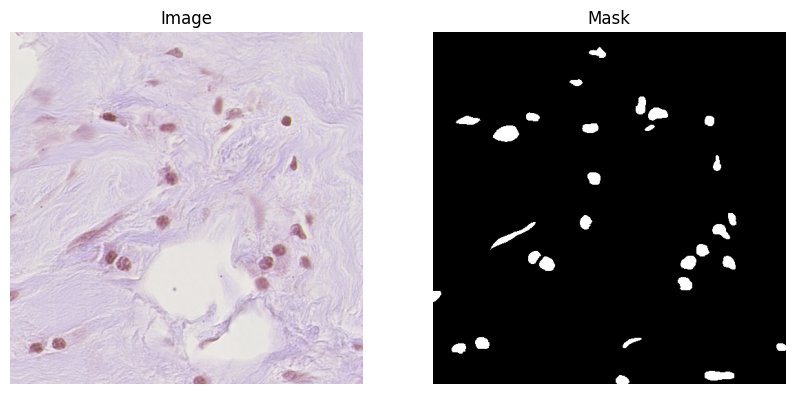

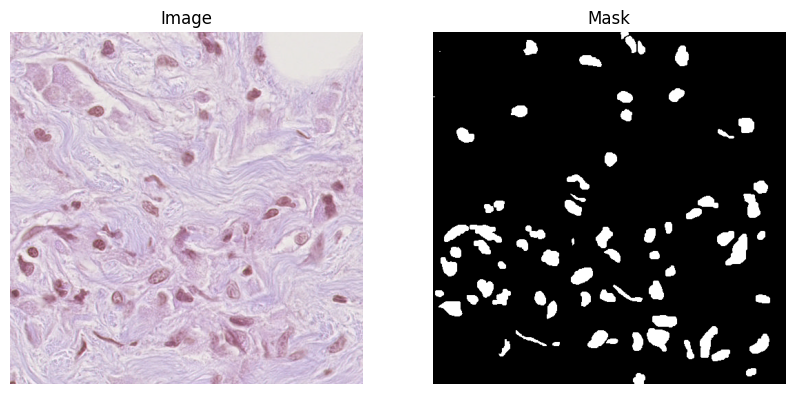

In [116]:
images, masks = load_images(10)
print(f'Primeira e ultima imagem importadas:')
show_img_and_mask(images[1], masks[1])
show_img_and_mask(images[-1], masks[-1])

## Image Segmentation

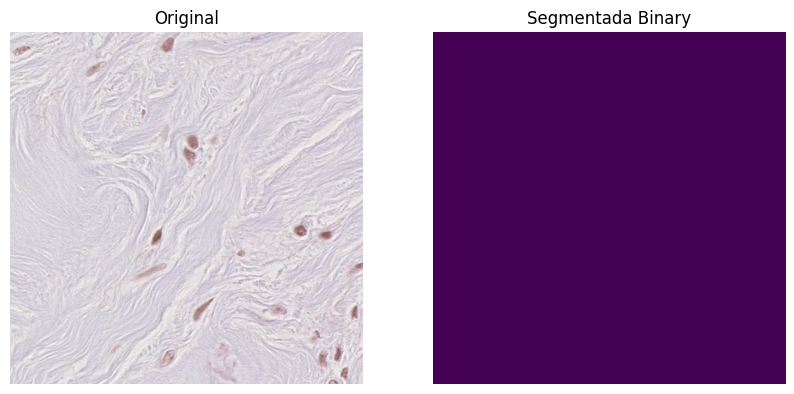

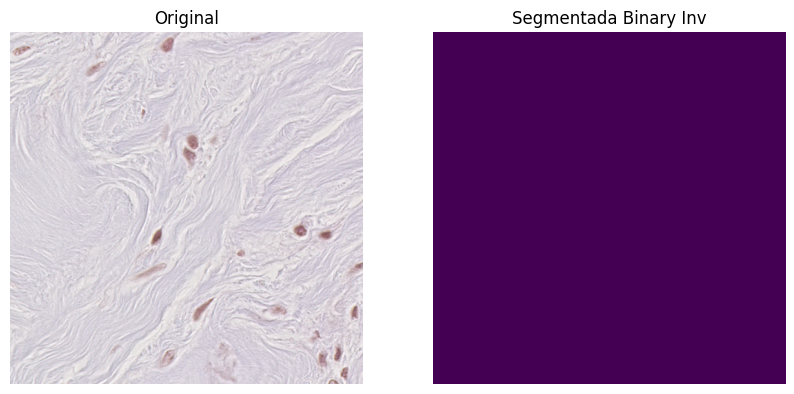

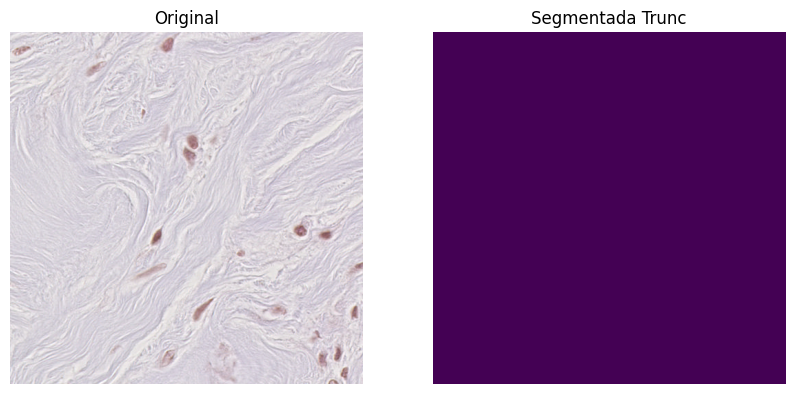

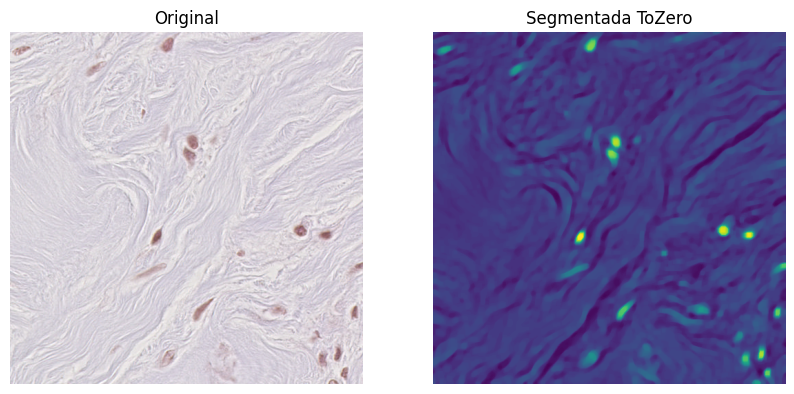

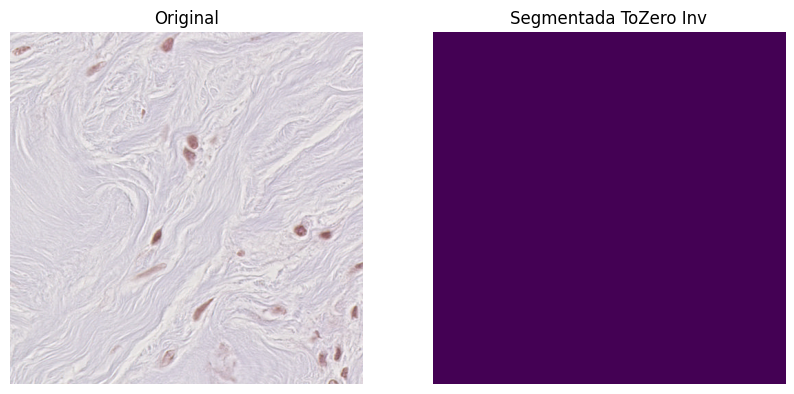

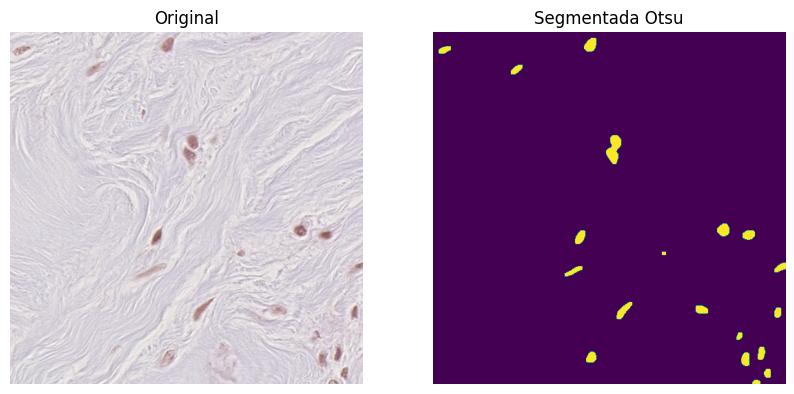

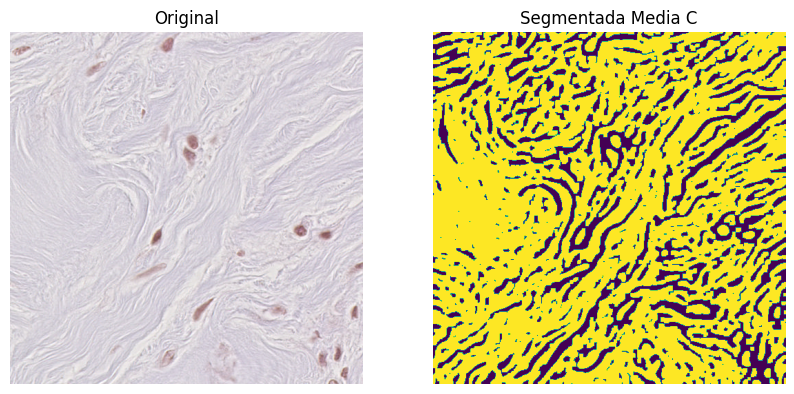

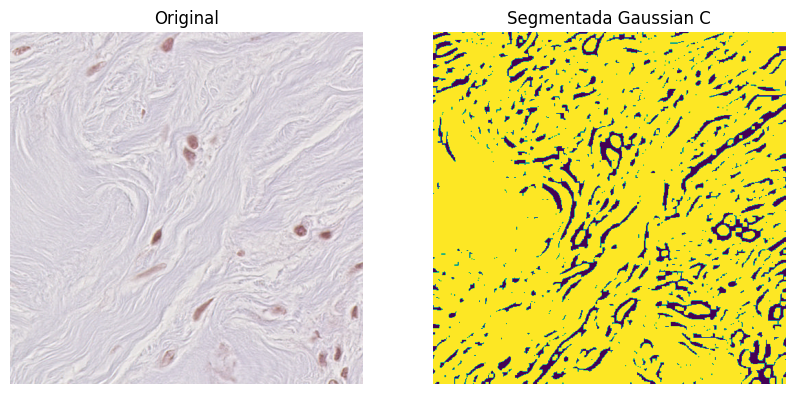

In [117]:
def segment_image_global(image, kernel_size = (3,3), method = cv2.THRESH_OTSU):
    kernel = np.ones(kernel_size, np.uint8)
    # Converter pra grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

    # As celulas do dataset sao preto no branco, entao temos que inverter a imagem, se nao as operacoes de erosao e dilatacao ficam "invertidas"
    gray = 255-gray
    
    # Gaussian blur de lei
    blurred = cv2.GaussianBlur(gray, (7,7), 0)

    # Filtro de mediana para suavizar o ruido
    blurred = cv2.medianBlur(blurred, 9)

    # Aplicando Threshold
    _, thresh = cv2.threshold(blurred, 0, 255, cv2.THRESH_BINARY + method)
    
    # Operacao de abertura para separar celulas
    opening = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, iterations=2)


    return opening

def segment_image_adaptative(image, kernel_size = (3,3), method = cv2.ADAPTIVE_THRESH_MEAN_C, block_size:int = 11, c:int = 2):
    kernel = np.ones(kernel_size, np.uint8)
    # Converter pra grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

    # As celulas do dataset sao preto no branco, entao temos que inverter a imagem, se nao as operacoes de erosao e dilatacao ficam "invertidas"
    gray = 255-gray
    
    # Gaussian blur de lei
    blurred = cv2.GaussianBlur(gray, (7,7), 0)

    # Filtro de mediana para suavizar o ruido
    blurred = cv2.medianBlur(blurred, 9)

    # Aplicando Threshold Adaptativo
    thresh = cv2.adaptiveThreshold(blurred, 255, method, cv2.THRESH_BINARY, block_size, c)
    
    # Operacao de abertura para separar celulas
    opening = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, iterations=2)

    return opening




#@TODO: Fazer uma segmentacao watershed, tinha tentado mas ela acabou sumindo com muita celula entao apaguei
compare_two_images(images[0], segment_image_global(images[0], method=cv2.THRESH_BINARY), "Original", "Segmentada Binary")
compare_two_images(images[0], segment_image_global(images[0], method=cv2.THRESH_BINARY_INV), "Original", "Segmentada Binary Inv")
compare_two_images(images[0], segment_image_global(images[0], method=cv2.THRESH_TRUNC), "Original", "Segmentada Trunc")
compare_two_images(images[0], segment_image_global(images[0], method=cv2.THRESH_TOZERO), "Original", "Segmentada ToZero")
compare_two_images(images[0], segment_image_global(images[0], method=cv2.THRESH_TOZERO_INV), "Original", "Segmentada ToZero Inv")
compare_two_images(images[0], segment_image_global(images[0]), "Original", "Segmentada Otsu")

compare_two_images(images[0], segment_image_adaptative(images[0]), "Original", "Segmentada Media C")
compare_two_images(images[0], segment_image_adaptative(images[0], method=cv2.ADAPTIVE_THRESH_GAUSSIAN_C), "Original", "Segmentada Gaussian C")


In [118]:
def watershed_markers(image, kernel_size=(3,3)):
    # Grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

    # Inverter a cor da imagem porque as celulas sao pretas e o fundo branco
    gray = 255 - gray
    
    # Aplicar blur para reduzir o ruido
    blurred = cv2.GaussianBlur(gray, (3,3), 0)
    
    # Aplicar threshold de Otsu 
    ret, thresh = cv2.threshold(blurred, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    
    # Remover o ruido com operacoes morfologicas
    kernel = np.ones(kernel_size, np.uint8)
    opening = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, iterations=2)
    
    # Area de fundo segura
    sure_bg = cv2.dilate(opening, kernel, iterations=2)
    
    # Finding sure foreground area
    dist_transform = cv2.distanceTransform(opening, cv2.DIST_L2, 5)
    ret, sure_fg = cv2.threshold(dist_transform, 0.4 * dist_transform.max(), 255, 0)
    
    # Finding unknown region
    sure_fg = np.uint8(sure_fg)
    unknown = cv2.subtract(sure_bg, sure_fg)
    
    # Marker labelling
    ret, markers = cv2.connectedComponents(sure_fg)
    markers = markers + 1
    markers[unknown == 255] = 0
    
    # Apply watershed
    markers = cv2.watershed(cv2.cvtColor(gray, cv2.COLOR_GRAY2BGR), markers)
    
    # Create binary output
    markers_binary = np.zeros_like(markers, dtype=np.uint8)
    markers_binary[markers > 1] = 255
    
    # Clean up small objects
    markers_binary = cv2.morphologyEx(markers_binary, cv2.MORPH_OPEN, kernel, iterations=1)
    
    return markers_binary


## Objects Counted

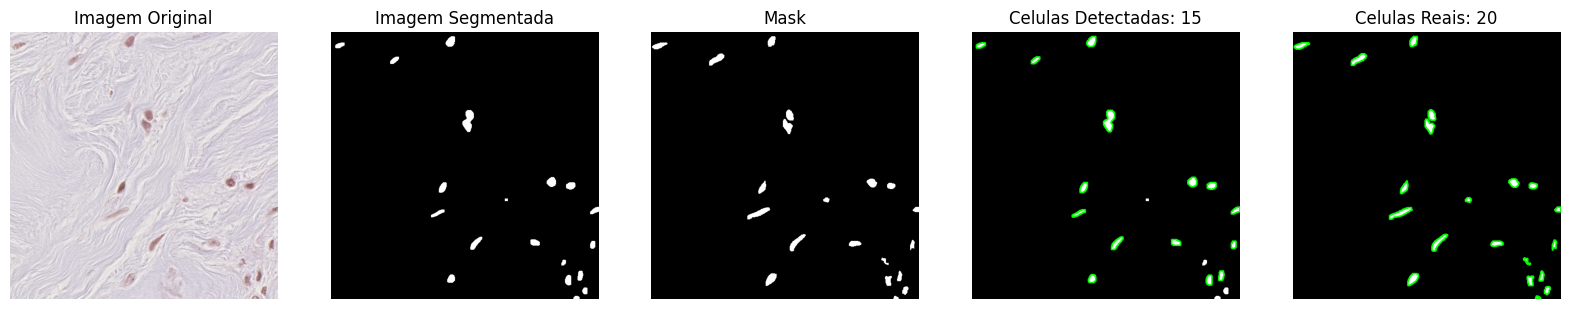

In [119]:
binary_image = segment_image_global(images[0])
contour_image, count = count_cells(binary_image)


plt.figure(figsize=(20, 5))
plt.subplot(151) 
plt.imshow(images[0])
plt.title('Imagem Original')
plt.axis('off')

plt.subplot(152)  
plt.imshow(binary_image, cmap='gray')
plt.title('Imagem Segmentada')
plt.axis('off')

plt.subplot(153) 
plt.imshow(masks[0])
plt.title('Mask')
plt.axis('off')

plt.subplot(154) 
plt.imshow(contour_image)
plt.title(f'Celulas Detectadas: {count}')
plt.axis('off')

plt.subplot(155)
mask_image, mask_count = count_cells(masks[0], min_area=1)   
plt.imshow(mask_image)
plt.title(f'Celulas Reais: {mask_count}')
plt.axis('off')

plt.show()


# COMPARISSON:

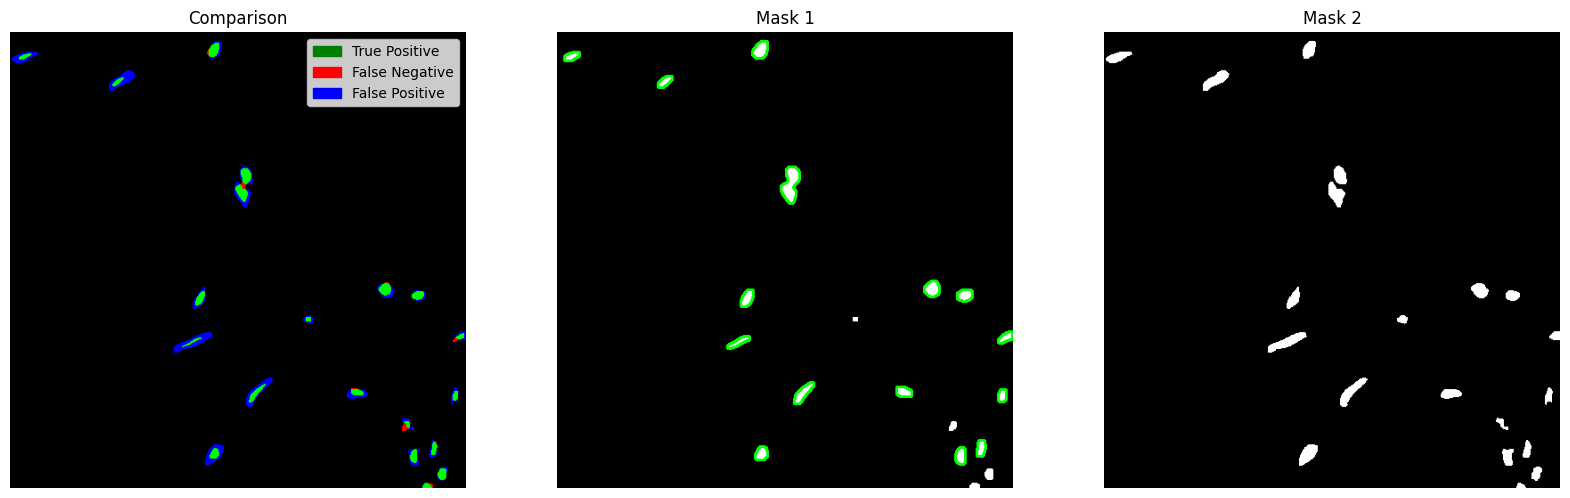

In [120]:
mask_comparison(contour_image, masks[0])

# Workflow

Celulas Detectadas Watershed: 100 | Celulas Detectadas Global: 16 | Celulas Reais: 20


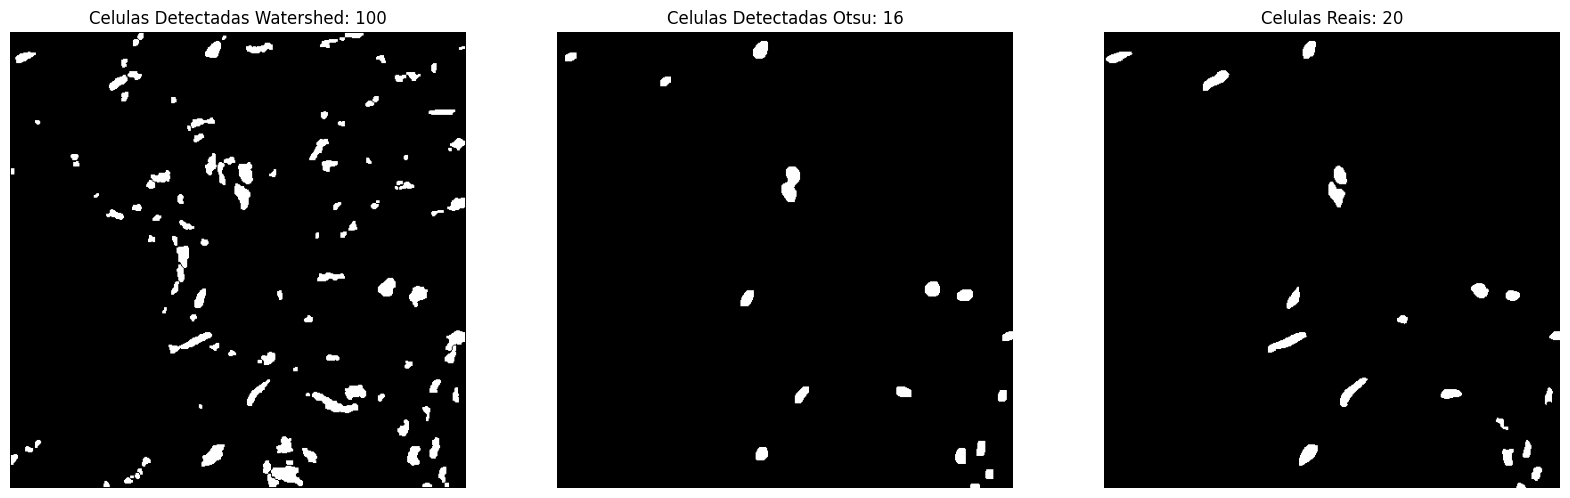

Celulas Detectadas Watershed: 28 | Celulas Detectadas Global: 33 | Celulas Reais: 29


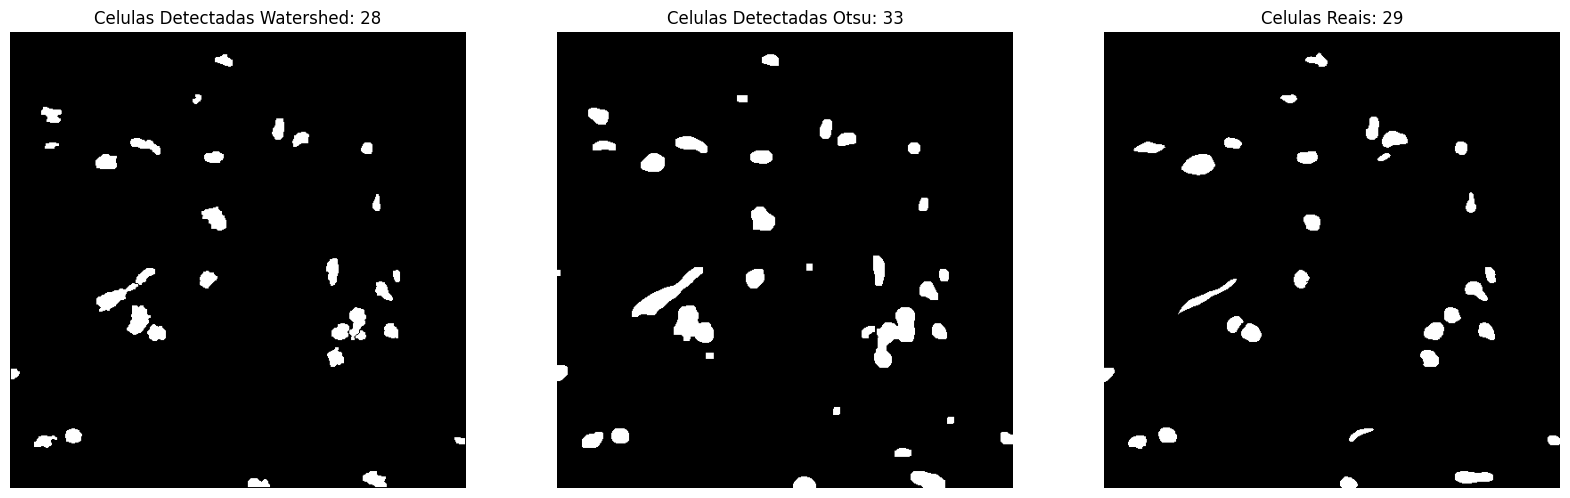

Celulas Detectadas Watershed: 68 | Celulas Detectadas Global: 114 | Celulas Reais: 103


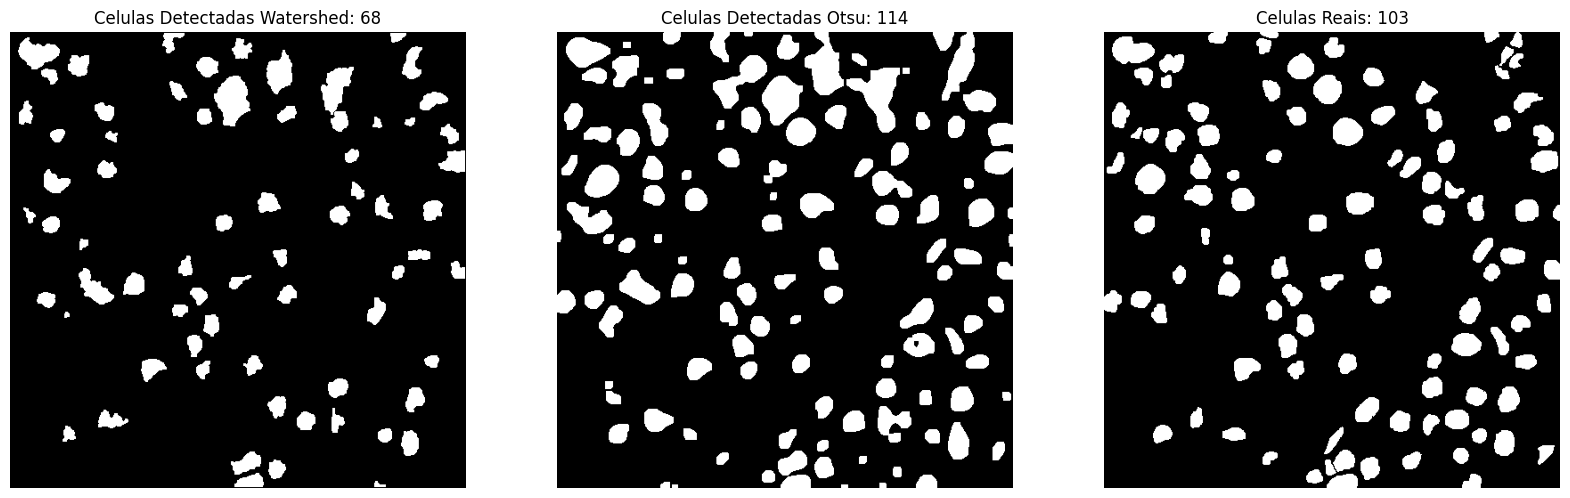

Celulas Detectadas Watershed: 56 | Celulas Detectadas Global: 58 | Celulas Reais: 66


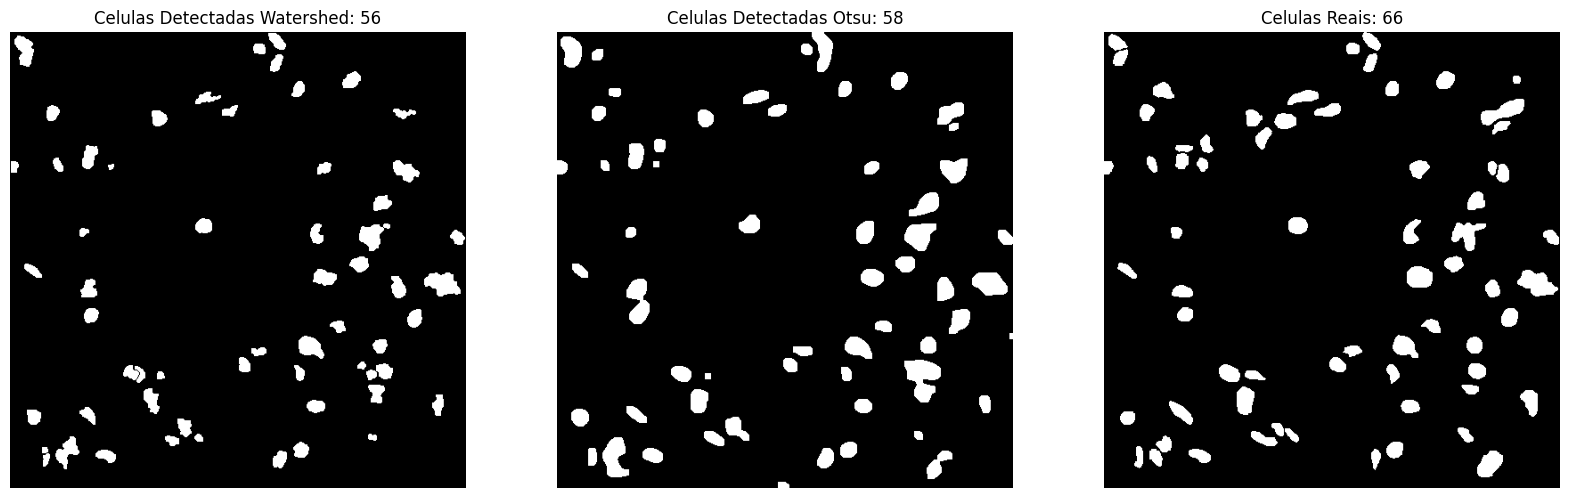

Celulas Detectadas Watershed: 63 | Celulas Detectadas Global: 65 | Celulas Reais: 71


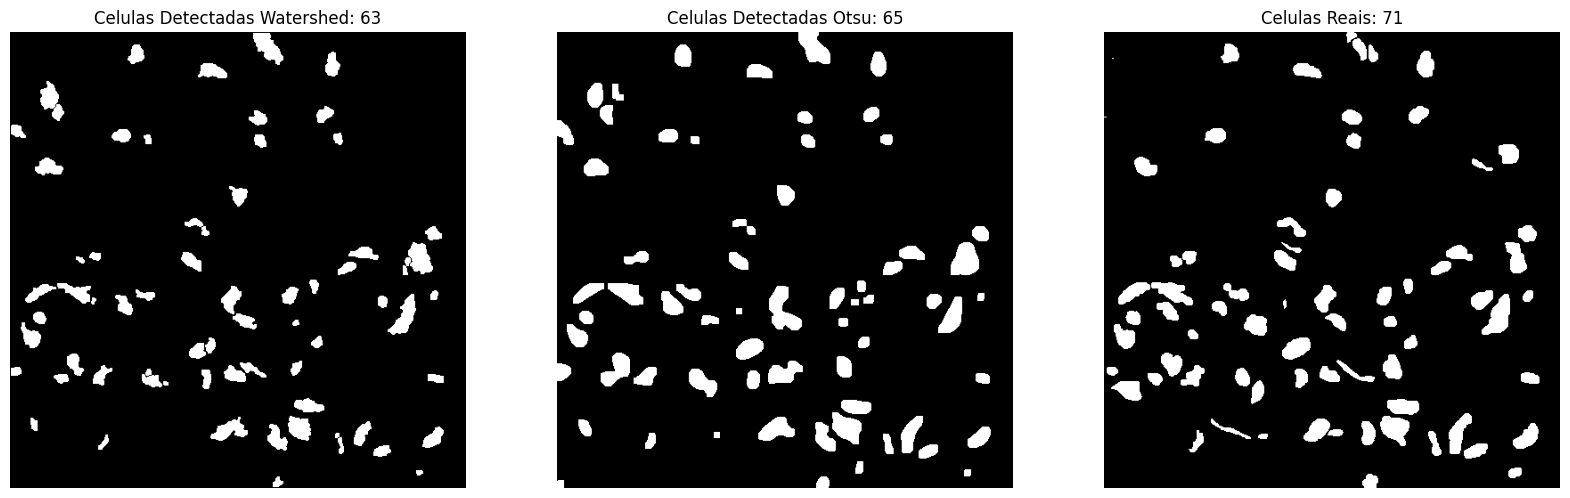

In [121]:
images, masks = load_images(10)

def super_sobel(img):
    img = 255 - img
    gauss_img = cv2.GaussianBlur(img, (9,9), 0)
    median_img = cv2.medianBlur(gauss_img, 15)
    tresh_gauss_c = segment_image_adaptative(median_img, method=cv2.ADAPTIVE_THRESH_GAUSSIAN_C)
    sobel1 = cv2.Sobel(tresh_gauss_c, cv2.CV_8U,1,0,ksize=5)
    sobel2 = cv2.Sobel(tresh_gauss_c, cv2.CV_8U,0,1,ksize=5)
    abs1 = cv2.convertScaleAbs(sobel1)
    abs2 = cv2.convertScaleAbs(sobel2)
    wsum = cv2.addWeighted(abs1,0.5, abs2, 0.5, 0)
    wsum[ wsum > 1 ] = 255
    wsum_gauss = cv2.GaussianBlur(wsum,(9,9), 0)
    wsum_gauss[ wsum_gauss > 1 ] = 255
    eroded = cv2.erode(wsum_gauss,np.ones((7,7), np.uint8))
    median_number_244123 = cv2.medianBlur(eroded, 9)
    return median_number_244123

for image, mask in zip(images, masks):
    binary_image_watershed = watershed_markers(image)
    binary_image_global = segment_image_global(image)
    binary_image_global = cv2.morphologyEx(binary_image_global, cv2.MORPH_OPEN, np.ones((3,3), np.uint8), iterations=3)


    count_watershed = count_connected_components(binary_image_watershed)
    count_global = count_connected_components(binary_image_global)
    mask_count = count_connected_components(mask)

    print(f'Celulas Detectadas Watershed: {count_watershed} | Celulas Detectadas Global: {count_global} | Celulas Reais: {mask_count}')
    plt.figure(figsize=(20, 20))
    
    plt.subplot(131)
    plt.imshow(binary_image_watershed, cmap='gray')
    plt.title(f'Celulas Detectadas Watershed: {count_watershed}')
    plt.axis('off')

    plt.subplot(132)
    plt.imshow(binary_image_global, cmap='gray')
    plt.title(f'Celulas Detectadas Otsu: {count_global}')
    plt.axis('off')


    plt.subplot(133)
    plt.imshow(mask, cmap='gray')
    plt.title(f'Celulas Reais: {mask_count}')
    plt.axis('off')



    plt.show()